# Facial Keypoint Detection
 
In this notebook, you will build a convolutional neural networks to perform facial keypoint detection.

Before we start, let's take a look at some example images and corresponding facial keypoints:

<img src='key_pts_example.png' width=50% height=50%/>

The facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc., and are relevant for a variety of computer vision tasks, such as face filters, emotion recognition, pose recognition, and more. 

# Preparation
## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from exercise_code.data.facial_keypoints_dataset import FacialKeypointsDataset
from exercise_code.networks.keypoint_nn import (
    DummyKeypointModel,
    KeypointModel
)
from exercise_code.util import (
    show_all_keypoints,
    save_model,
)
from exercise_code.tests import test_keypoint_nn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load and Visualize Data
To load the data, we have already prepared a Pytorch Dataset class `FacialKeypointsDataset` for you. You can find it in `exercise_code/data/facial_keypoints/dataset.py`. Run the following cell to download the data and initialize your dataset:

In [2]:
download_url = 'http://filecremers3.informatik.tu-muenchen.de/~dl4cv/training.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=transforms.ToTensor(),
    root=data_root,
    download_url=download_url
)
val_dataset = FacialKeypointsDataset(
    train=False,
    transform=transforms.ToTensor(),
    root=data_root,
)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 1546
Number of validation samples: 298


Each sample in our dataset is a dict `{"image": image, "keypoints": keypoints}`, where
 * `image` is a [0-1]-normalized gray-scale image of size 96x96, represented by a torch tensor of shape (CxHxW) with C=1, H=96, W=96
    <img style="float: right;" src='key_pts_expl.png' width=50% height=50%/>
 * `keypoints` is the list of K facial keypoints, stored in a torch tensor of shape (Kx2). We have K=15 keypoints that stand for:
   * keypoints[0]: Center of the left eye
   * keypoints[1]: Center of the right eye
   * keypoints[2]: Left eye inner corner
   * keypoints[3]: Left eye outer corner
   * keypoints[4]: Right eye inner corner
   * keypoints[5]: Right eye outer corner
   * keypoints[6]: Left eyebrow inner end
   * keypoints[7]: Left eyebrow outer end
   * keypoints[8]: Right eyebrow inner end
   * keypoints[9]: Right eyebrow outer end
   * keypoints[10]: Nose tip
   * keypoints[11]: Mouth left corner
   * keypoints[12]: Mouth right corner
   * keypoints[13]: Mouth center top lip
   * keypoints[14]: Mouth center bottom lip

   
Each individual facial keypoint is represented by two coordinates (x,y) that specify the horizontal and vertical location of the keypoint respectively. All keypoint values are normalized to [-1,1], such that:
   * (x=-1,y=-1) corresponds to the top left corner, 
   * (x=-1,y=1) to the bottom left corner,
   * (x=1,y=-1) to the top right corner,
   * (x=1,y=1) to the bottom right corner,
   * and (x=0,y=0) to the center of the image.

Let's have a look at the first training sample to get a better feeling for the dataset:

In [3]:
image, keypoints = train_dataset[0]["image"], train_dataset[0]["keypoints"]
print("Shape of the image:", image.size())
print("Smallest value in the image:", torch.min(image))
print("Largest value in the image:", torch.max(image))
print(image)

Shape of the image: torch.Size([1, 96, 96])
Smallest value in the image: tensor(0.0118)
Largest value in the image: tensor(1.)
tensor([[[0.3804, 0.2039, 0.2275,  ..., 0.9922, 0.9961, 0.9961],
         [0.3333, 0.2157, 0.2588,  ..., 0.9922, 0.9961, 0.9961],
         [0.2941, 0.2588, 0.2902,  ..., 0.9922, 0.9961, 0.9961],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.9255, 1.0000, 1.0000],
         [0.1294, 0.1255, 0.1216,  ..., 0.9490, 0.9843, 0.9804],
         [0.1216, 0.1176, 0.1216,  ..., 0.9255, 1.0000, 0.9922]]])


In [4]:
keypoints = train_dataset[0]["keypoints"]
print(keypoints)

tensor([[ 0.4685, -0.2319],
        [-0.4253, -0.1953],
        [ 0.2908, -0.2214],
        [ 0.5992, -0.2214],
        [-0.2685, -0.2109],
        [-0.5873, -0.1900],
        [ 0.1967, -0.3827],
        [ 0.7656, -0.4295],
        [-0.2035, -0.3758],
        [-0.7389, -0.3573],
        [ 0.0086,  0.2333],
        [ 0.4163,  0.6620],
        [-0.3521,  0.6985],
        [ 0.0138,  0.6045],
        [ 0.0190,  0.9076]])


In `exercise_code/util/vis_utils.py` we also provide you with a function `show_all_keypoints()` that takes in an image and keypoints and displays where the predicted keypoints are in the image. Let's use it to plot the first few images of our training set:

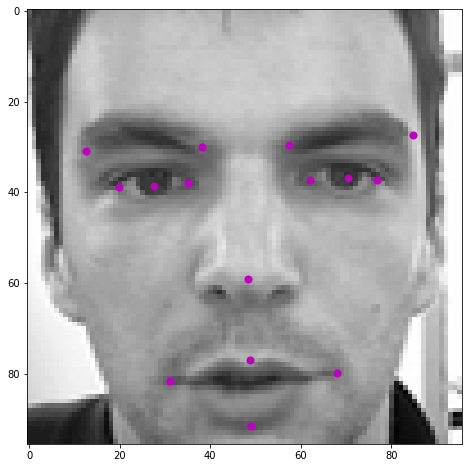

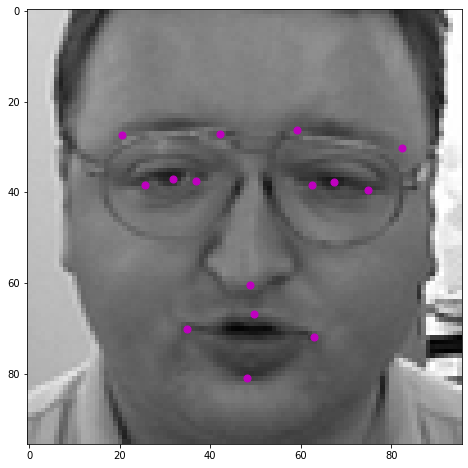

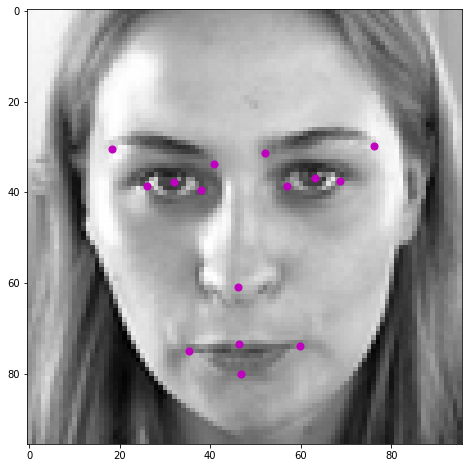

In [5]:
def show_keypoints(dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        show_all_keypoints(image, key_pts)
show_keypoints(train_dataset)

# Facial Keypoint Detection
Your task is to define and train a model for facial keypoint detection.

The facial keypoint detection task can be seen as a regression problem, where the goal is to predict 30 different values that correspond to the 15 facial keypoint locations. Thus, we need to build a network that gets a (1x96x96) image as input and predicts 30 continuous outputs between [-1,1].

## Dummy Model
In `exercise_code/networks/dummy_network.py` we defined a naive `DummyModel`, which always predicts the keypoints of the first training image. Let's try it on a few images and visualize our predictions in red:

In [6]:
def show_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15,2)
        show_all_keypoints(image, key_pts, predicted_keypoints)

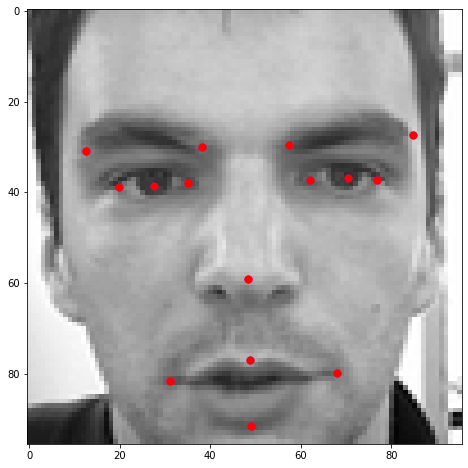

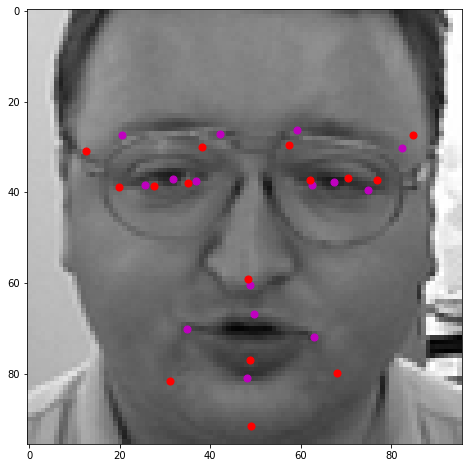

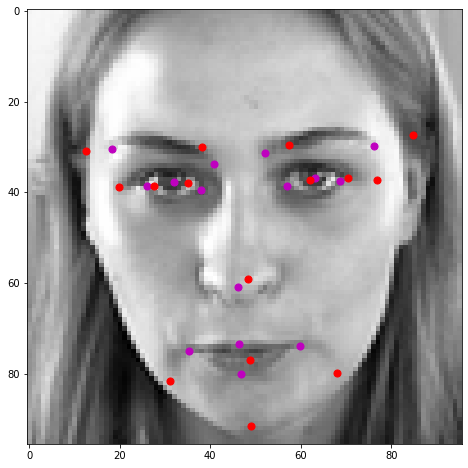

In [7]:
dummy_model = DummyKeypointModel()
show_keypoint_predictions(dummy_model, train_dataset)

As we see, the model predicts the first sample perfectly, but for the remaining samples the predictions are quite off.

## Loss and Metrics

To measure the quality of the model's predictions, we will use the mean squared error (https://en.wikipedia.org/wiki/Mean_squared_error), summed up over all 30 keypoint locations. In PyTorch, the mean squared error is defined in `torch.nn.MSELoss()`, and we can use it like this:

In [8]:
loss_fn = torch.nn.MSELoss()
for i in range(3):
    image = train_dataset[i]["image"]
    keypoints = train_dataset[i]["keypoints"]
    predicted_keypoints = torch.squeeze(dummy_model(image)).view(15,2)
    loss = loss_fn(keypoints, predicted_keypoints)
    print("Loss on image %d:" % i, loss)

Loss on image 0: tensor(9.3016e-10)
Loss on image 1: tensor(0.0094)
Loss on image 2: tensor(0.0102)


As expected, our dummy model achieves a loss close to 0 on the first sample, but on all other samples the loss is quite high.

To obtain an evaluation score (in the notebook and on the submission server), we will use the following function:

In [9]:
def evaluate_model(model, dataset):
    model.eval()
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"], batch["keypoints"]
        predicted_keypoints = model(image).view(-1,15,2)
        loss += criterion(
            torch.squeeze(keypoints),
            torch.squeeze(predicted_keypoints)
        ).item()
    return 1.0 / (2 * (loss/len(dataloader)))

print("Score:", evaluate_model(dummy_model, val_dataset))

Score: 60.19574733338525


**To pass the assignment, you will need to achieve a score of at least 100**. As you can see, the score is calculated from the average loss, so **your average loss needs to be lower than 0.005**. Our dummy model only gets a score of around 60, so you will have to come up with a better model.

## Step 1: Design your own model
Now it is your turn to build your own model. To do so, you need to design a convolutional neural network that takes images of size (Nx1x96x96) as input and produces outputs of shape (Nx30) in the range [-1,1].

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You can design your network however you want, but we strongly suggest to include multiple convolutional layers. You are also encouraged to use things like dropout and batch normalization to stabilize and regularize your network. If you want to build a really competitive model, have a look at some literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf).

#### Define your model in the provided file `exercise_code/classifiers/keypoint_nn.py` file

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from torch.nn.Module or pytorch_lightning.LightningModule
* Perform the forward pass in forward(), predicting keypoints of shape (Nx30) for images of shape (Nx1x96x96)
* Have less than 5 million parameters
* Have a model size of less than 20MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict

In [96]:
hparams = {'batch_size' : 128, 'n_hidden': 380, 'lr': 1e-4, 'reg': 1e-3}

To test whether your model follows the basic rules, run the following cell:

In [97]:
from exercise_code.networks.keypoint_nn import (
    DummyKeypointModel,
    KeypointModel
)
model = KeypointModel(hparams)
test_keypoint_nn(model)

KeypointShapeTest passed.
ParamCountTest passed. Your model has 4.969 mio. params.
FileSizeTest passed. Your model is 19.9 MB large
All tests passed for your model. Tests passed: 3/3


## Step 2: Train your model
In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.

**Hints:**
* Use torch.nn.MSELoss() as loss function
* Have a look at the previous notebooks for PyTorch and PyTorch Lightning in exercises 7 and 8 if you feel lost. In particular, revise 4_Cifar10_PytorchLightning.ipynb in exercise 8.

In [98]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [99]:
trainer = Trainer(gpus=-1, max_epochs=500, reload_dataloaders_every_epoch=True, benchmark=True)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [100]:
model = KeypointModel(hparams)

In [101]:
hparams = {'batch_size' : 64, 'n_hidden': 380, 'lr': 1e-4, 'reg': 1e-3}
model = KeypointModel(hparams)
trainer.fit(model)


  | Name  | Type      | Params
--------------------------------
0 | conv1 | Conv2d    | 832   
1 | pool1 | MaxPool2d | 0     
2 | conv2 | Conv2d    | 18 K  
3 | pool2 | MaxPool2d | 0     
4 | conv3 | Conv2d    | 73 K  
5 | pool3 | MaxPool2d | 0     
6 | fc1   | Linear    | 4 M   
7 | fc2   | Linear    | 11 K  


1

In [102]:
model

KeypointModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=380, bias=True)
  (fc2): Linear(in_features=380, out_features=30, bias=True)
)

When you're done training, run the cells below to visualize some predictions of your model, and to compute a validation score:

In [103]:
device = torch.device('cuda:0')
def show_keypoint_predictions_overwrite(model, dataset, num_samples=3):
    model.eval()
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        image = image.to(device)
        predicted_keypoints = torch.squeeze(model(image.view(1,1,96,96)).detach()).view(15,2)
        show_all_keypoints(image.to('cpu'), key_pts, predicted_keypoints.to('cpu'))

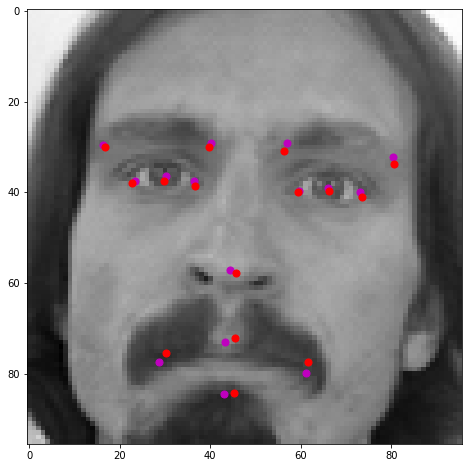

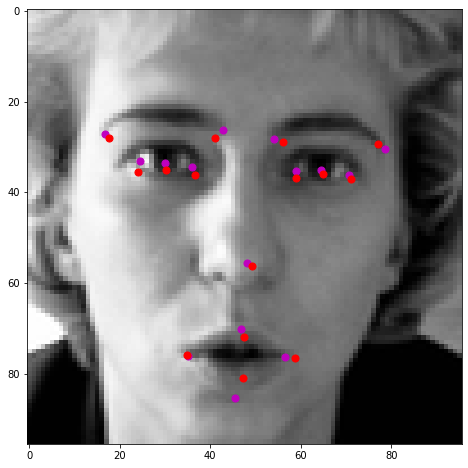

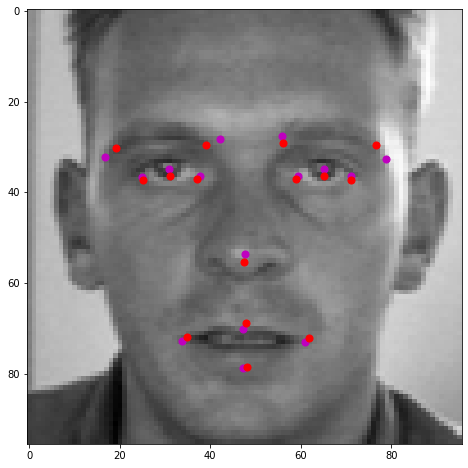

In [104]:
show_keypoint_predictions_overwrite(model, val_dataset)

In [105]:
def evaluate_model_overwrite(model, dataset):
    model.eval()
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"], batch["keypoints"]
        image = image.to(device)
        predicted_keypoints = model(image).view(-1,15,2)
        loss += criterion(
            torch.squeeze(keypoints),
            torch.squeeze(predicted_keypoints.to('cpu'))
        ).item()
    return 1.0 / (2 * (loss/len(dataloader)))

print("Score:", evaluate_model_overwrite(model, val_dataset))

Score: 272.6969958890313


## Save Your Model

If your model achieved a validation score of 100 or higher, save your model with the cell below and submit it to the submission server.

In [106]:
save_model(model, "facial_keypoints.p")

'models/facial_keypoints.p'

# Submission Instructions
1. Go on [our submission page](https://dvl.in.tum.de/teaching/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Navigate to `exercise_code` directory and run the `create_submission.sh` file to create the zip file of your model. This will create a single `zip` file that you need to upload. Otherwise, you can also zip it manually if you don't want to use the bash script. However, **make sure that the structure of the zip file is the same** as it would be when generated with the bash-script.
3. Log into [our submission page](https://dvl.in.tum.de/teaching/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
4. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Implement and train a convolutional neural network for facial keypoint detection.
- Passing Criteria: Reach **Score >= 100** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Saturday, June 27, 2020 - 12:00__
- Submission deadline : __Friday, July 03, 2020 - 23:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus